# Simple regression

In [1]:
import jax
import jax.numpy as jnp
from pcv.inference import run_cv_sel, fold_adaptation, inference
from pcv.plots import plot_model_results, plot_fold_results
from pcv.models import reg
from pcv.rules import make_positive_rule, make_positive_negative_rule
import matplotlib.pyplot as plt
import arviz as az

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Model definition

Gaussian linear regression, with an outlier injected into the data

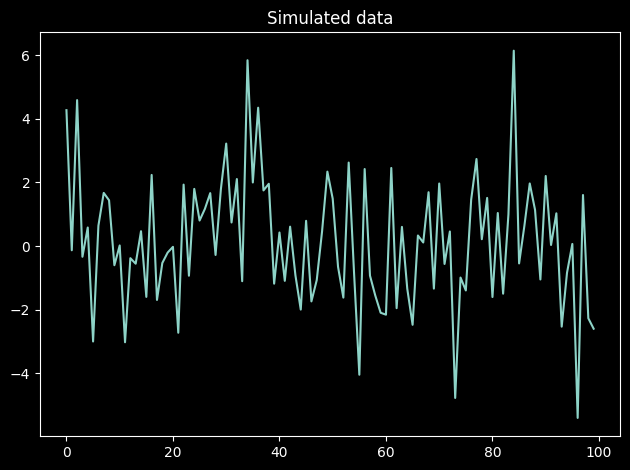

In [2]:
y, X = reg.generate(
    key=jax.random.PRNGKey(0),
    N = 100,
    beta0 = jnp.array([1.0, 1.0, 1.0, 0.5]),
    sigsq0 = jnp.array(2.0))

plt.plot(y)
plt.title('Simulated data')
plt.tight_layout()

In [3]:
K = 10
model = reg.get_model(y, X, K=K)

In [4]:
idata, state, trace = inference(
    prng_key=jax.random.PRNGKey(0),
    model=model,
    model_id=0,
    num_chains=32,
    num_samples=10_000,
    warmup_iter=10_000,
    prior_only=False
)

In [5]:
a = jax.vmap(model.to_constrained)(trace)

In [6]:
az.summary(idata, var_names=['beta', 'sigsq'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.774,0.146,0.501,1.052,0.001,0.000,60785.0,98506.0,1.0
beta[1],0.813,0.140,0.552,1.079,0.001,0.000,60730.0,98365.0,1.0
beta[2],0.831,0.125,0.596,1.065,0.000,0.000,77030.0,118877.0,1.0
beta[3],0.371,0.138,0.110,0.630,0.001,0.000,56650.0,91441.0,1.0
sigsq,1.911,0.272,1.423,2.425,0.001,0.001,72971.0,108750.0,1.0


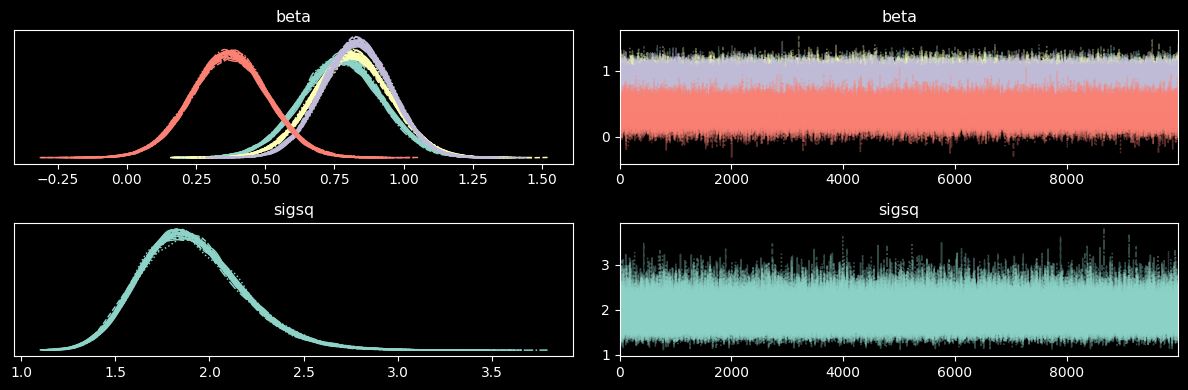

In [7]:
axes = az.plot_trace(idata)
plt.tight_layout()

In [8]:
# state, params = full_data_warmup(
#     prng_key=jax.random.PRNGKey(0),
#     logjoint_density=logjoint_density,
#     make_initial_pos=make_initial_pos,
#     num_chains=32,
#     batch_size=100,
#     warmup_iter=10000,
#     model_id=0,
#     prior_only=False
# )

## CV


In [9]:
# state, params = cv_warmup(
#     prng_key=jax.random.PRNGKey(0),
#     logjoint_density=logjoint_density,
#     make_initial_pos=make_initial_pos,
#     num_folds=K,
#     num_chains=32,
#     batch_size=100,
#     warmup_iter=10000
# )

In [10]:
# params.keys()

In [11]:
# fig, axes = plt.subplots(1, 4, figsize=(10, 4))
# p_al, p_del, p_step, p_momentum = axes
# p_al.hist(params['alpha'])
# p_al.set_title('alpha')
# p_del.hist(params['delta'])
# p_del.set_title('delta')
# p_step.hist(params['step_size'])
# p_step.set_title('step_size')
# fig.tight_layout()

In [12]:
warmup = fold_adaptation(
    prng_key=jax.random.PRNGKey(0),
    model=model,
    num_chains=32,
    model_warmup_iter=10_000,
    fold_warmup_iter=10_000,
)

MEADS warmup for 2 model(s) (64 chains)...
Meads warmup done in 3.44 seconds. 
Step size: [0.4915831 0.5219323] Alpha: [0.6314851 0.652112 ] Delta: [0.31574255 0.326056  ]
MEADS warmup for 10 folds per model (640 chains)...
MEADS warmup took 0 min 7.6 sec


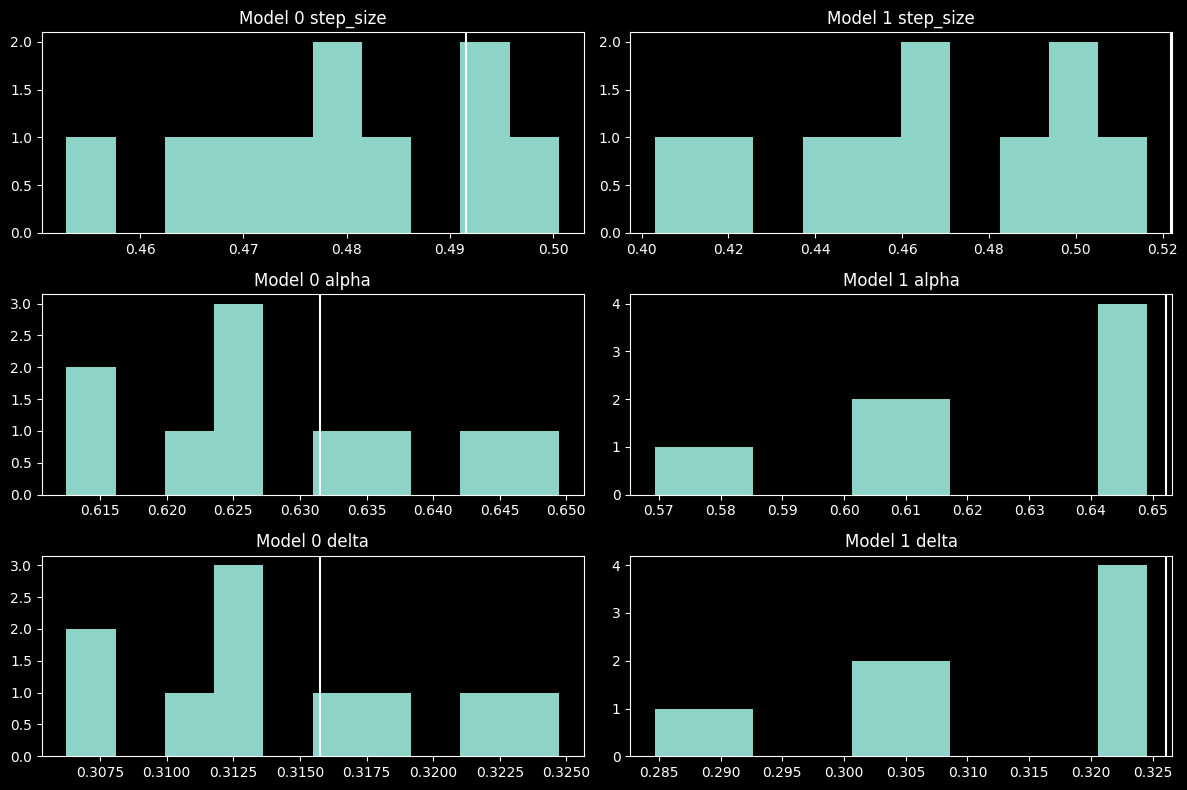

In [13]:
warmup.plot_dist()

In [16]:
results = run_cv_sel(
       prng_key=jax.random.PRNGKey(0),
       model=model,
       stoprule=make_positive_negative_rule(num_folds=model.num_folds, level=0.95),
       warmup_results=warmup,
       batch_size=100,
       max_batches=50,
       ignore_stoprule=True,
       prior_only=False
)

Starting cross-validation with 640 parallel GHMC chains...


ValueError: vmap was requested to map its argument along axis 0, which implies that its rank should be at least 1, but is only 0 (its shape is ())

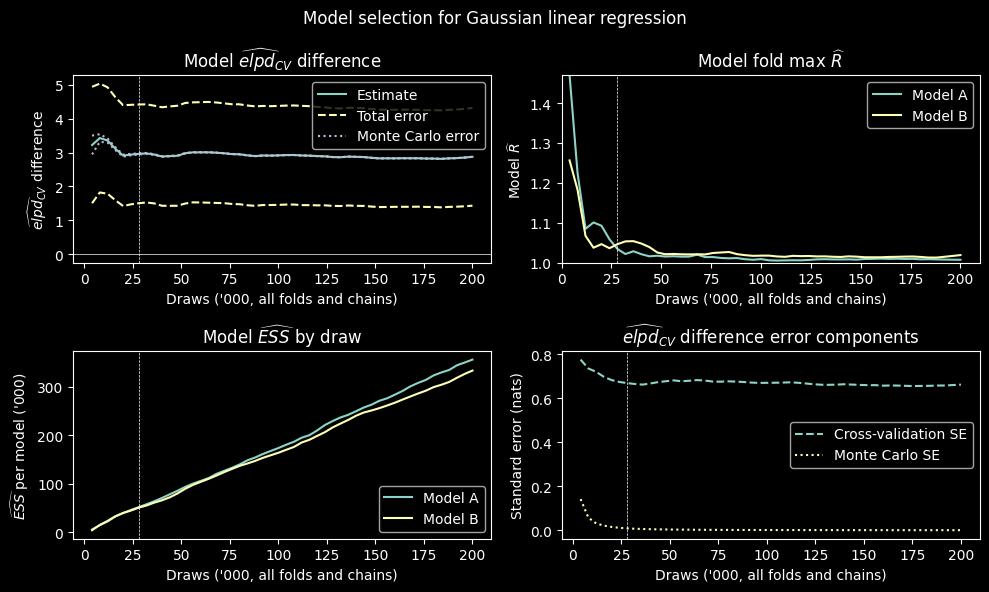

In [ ]:
plot_model_results(results, title="Model selection for Gaussian linear regression")

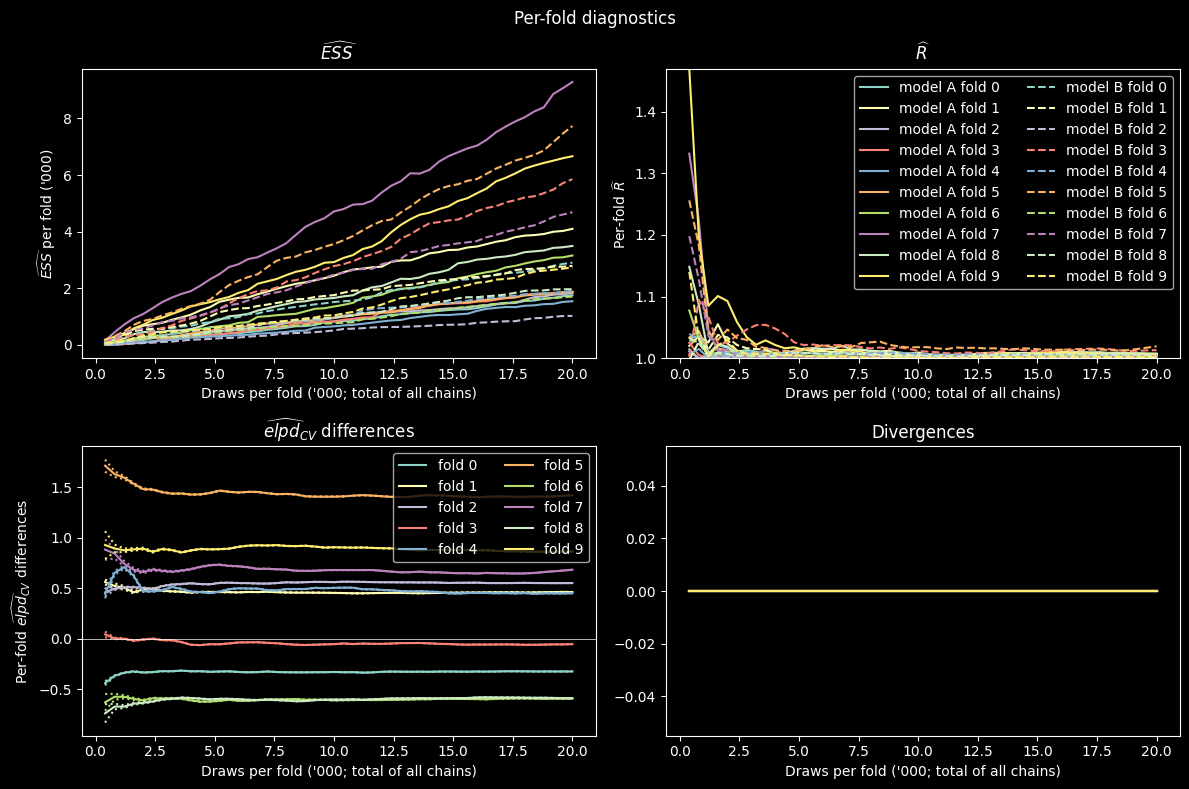

In [ ]:
plot_fold_results(results, title='Per-fold diagnostics')

In [ ]:
warmup_results = fold_adaptation(
    prng_key = jax.random.PRNGKey(0),
    logjoint_density = logjoint_density,
    make_initial_pos = make_initial_pos,
    num_models = 2,
    num_folds = 10,
    num_chains = 16,
    model_warmup_iter = 20_000,
    fold_warmup_iter = 10_000,
)

MEADS warmup for 2 model(s) (32 chains)...
Meads warmup done in 5.12 seconds. 
Step size: [0.41927725 0.406279  ] Alpha: [0.5619334  0.54439664] Delta: [0.2809667  0.27219832]
MEADS warmup for 10 folds per model (320 chains)...
MEADS warmup took 4.99 seconds


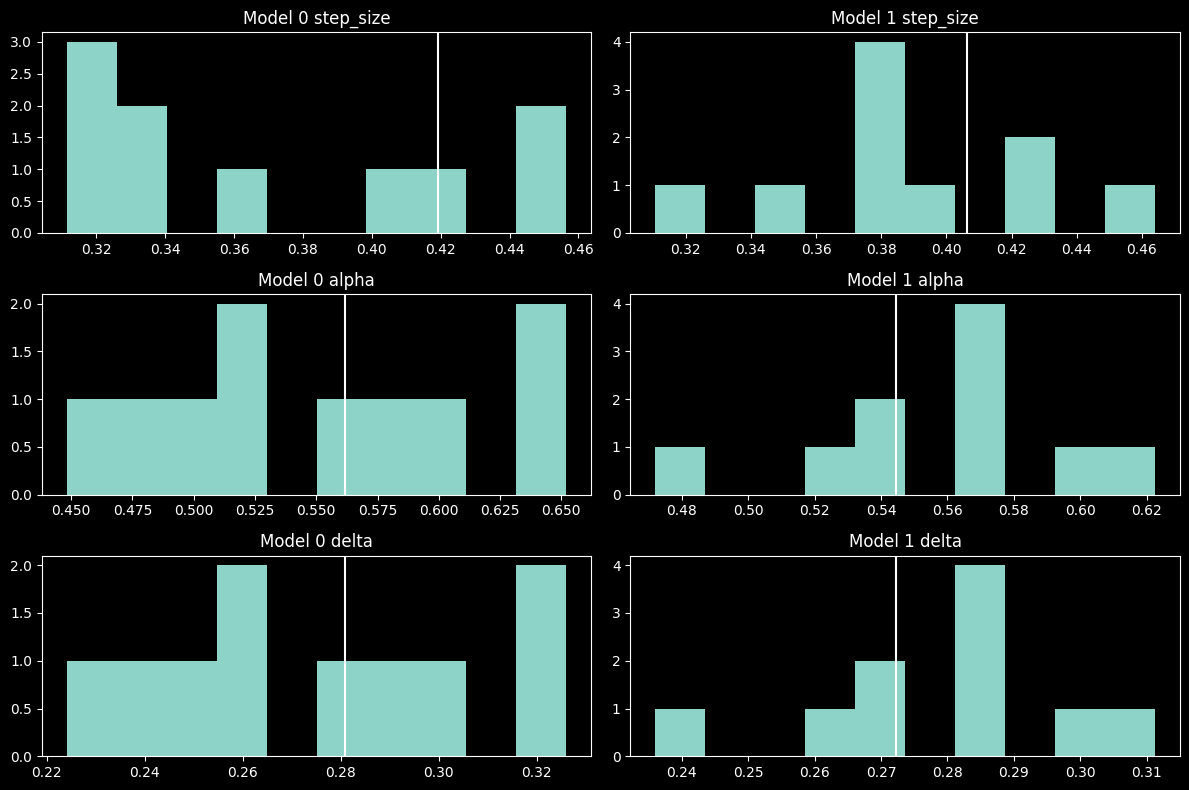

In [ ]:
warmup_results.plot_dist()